# FMR_CPW_1a




In [1]:
import sys
sys.path.append("..")

import display as disp
import shapes as shp

from export import dxf, gds, frozen_notebook

import shapely as sp
from shapely import affinity as aff
from shapely.geometry import Point, LineString, Polygon, MultiLineString, MultiPolygon

import numpy as np
import re

<IPython.core.display.Javascript object>

### Parameters
Defining all the parameters.

In [2]:
s = 15. #cpwg s
w = 8.74 #cpwg w

launcher_width = 240. #launcher bondingpad size
launcher_transition = 200. #launcher triangle length
launcher_gap = 100. #gap around bonding pad of launcher

margin = 20. #empty region around edge of WF
WF = 3000 #WF size

meander_r = 3*s + 23 #meander radius

inlauncher_width = 100 # width on inlauncher triangle base
inlauncher_length = 100 #length of inlauncher triangle
inlauncher_gap = 100 #gap around inlauncher
inlauncher_leggap = 3 #width of legs on inlauncher


### Launcher


In [3]:
launchL, _, _ = shp.launcher( s, w,
                        launcher_width, launcher_width , launcher_transition, launcher_gap )
launchR = aff.rotate( launchL , angle=180, origin=(0,0) )
b = launchL.bounds
lw = b[2] - b[0]
lh = b[3] - b[1]
launchL = aff.translate( launchL, WF-margin-b[2] , lh/2+margin )
launchR = aff.translate( launchR, lw+margin, lh/2+margin )

feed_line = LineString(
    ((lw+margin,lh/2+margin),
     (WF-margin-lw,lh/2+margin))
)
feed_lineL, feed_lineR, _, _ = shp.line_to_cpwg( feed_line, s, w )

feedline_with_launchers = MultiPolygon( (launchL, launchR, feed_lineL, feed_lineR ) )

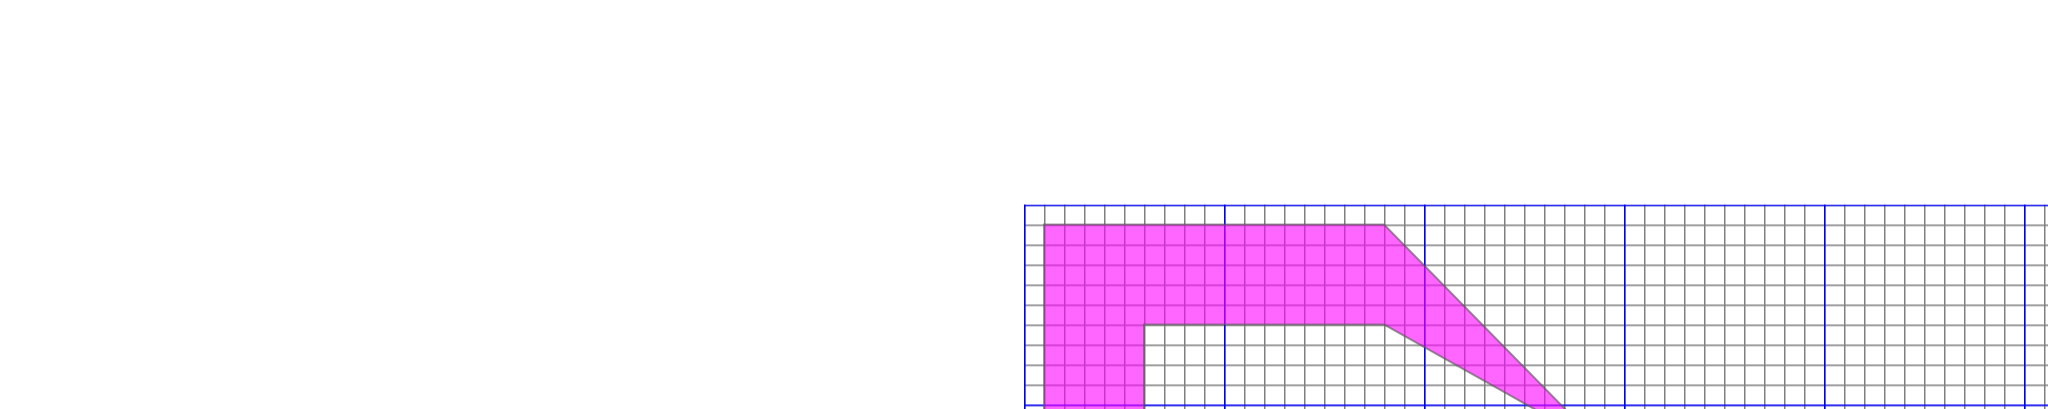

In [4]:
disp.display_svg([
    disp.generate_svg_grid(0,0,WF,WF,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( launchL, attribs={'fill':'#ff0'} ),
    disp.nice_svg( launchR, attribs={'fill':'#f0f'} ),
    disp.nice_svg( feed_lineL, attribs={'fill':'#0ff'} ),
    disp.nice_svg( feed_lineR, attribs={'fill':'#0f0'} ),
], (0,0,WF,WF/5)
)

### Meander

In [10]:
l = 1000
n = 5
r = meander_r
d = 2*r
n_turns = 10
sample_size = 3000
spacing_y = 250
overlap = 1

In [23]:
hanger_start =     ((lw+margin-overlap,lh/2+margin),
     (WF-margin-lw,lh/2+margin))

segments = []

# straight (right)

segments.append( LineString([
    Point(hanger_start),
    aff.translate( Point(hanger_start), 100, 0 ),
]) )

# turn right

segments.append( shp.circle_segment(
    aff.translate( Point(segments[-1].coords[-1]), 0, meander_r ),
    meander_r, np.pi, np.pi/2, 30
) )

# straight (down)

segments.append( LineString([
    Point(segments[-1].coords[-1]),
    aff.translate( Point(segments[-1].coords[-1]), 0, spacing_y ),
]) )

# arc right

segments.append( shp.circle_segment(
    aff.translate( Point(segments[-1].coords[-1]), -meander_r, 0 ),
    meander_r, np.pi/2, 0, 30
) )

# straight (left)

segments.append( LineString([
    Point(segments[-1].coords[-1]),
    aff.translate( Point(segments[-1].coords[-1]), -(launcher_width + launcher_gap + 200), 0 ),
]) )

# arc (left)

segments.append( shp.circle_segment(
    aff.translate( Point(segments[-1].coords[-1]), 0, meander_r ),
    meander_r, np.pi, np.pi*1.5, 30
))

# straight (down)

segments.append( LineString([
    Point(segments[-1].coords[-1]),
    aff.translate( Point(segments[-1].coords[-1]), 0, 2* meander_r + 100),
]) )
    

################ loop for meandering part ###############
for i in range(n_turns):

    # straight (down)

    segments.append( LineString([
        Point(segments[-1].coords[-1]),
        aff.translate( Point(segments[-1].coords[-1]), 0, sample_size ),
    ]) )
    
    # bottom arc

    segments.append( shp.circle_segment(
        aff.translate( Point(segments[-1].coords[-1]), meander_r, 0),
        meander_r, -np.pi*1/2, np.pi*1/2, 30
    ))
    
    # straight (up)

   
    segments.append( LineString([
        Point(segments[-1].coords[-1]),
        aff.translate( Point(segments[-1].coords[-1]), 0, -sample_size ), 
    ]) )
    
    # top arc

    segments.append( shp.circle_segment(
        aff.translate( Point(segments[-1].coords[-1]), meander_r, 0),
        meander_r, np.pi*3/2, np.pi*1/2, 30
    ))

############### end of loop, back to the launcher ###############

# straight (down)

segments.append( LineString([
    Point(segments[-1].coords[-1]),
    aff.translate( Point(segments[-1].coords[-1]), 0, sample_size ),
]) )

# bottom arc

segments.append( shp.circle_segment(
    aff.translate( Point(segments[-1].coords[-1]), meander_r, 0),
    meander_r, -np.pi*1/2, np.pi*1/2, 30
))

# straight (up)

segments.append( LineString([
    Point(segments[-1].coords[-1]),
    aff.translate( Point(segments[-1].coords[-1]), 0, -(sample_size + 2* meander_r  + 100 ) ), 
]) )

# arc (left)

segments.append( shp.circle_segment(
    aff.translate( Point(segments[-1].coords[-1]), -meander_r, 0 ),
    meander_r, np.pi/2, np.pi, 30
))


# straight (left)

segments.append( LineString([
    Point(segments[-1].coords[-1]),
    aff.translate( Point(segments[-1].coords[-1]), -600, 0 ), 
]) )

# arc (right)

segments.append( shp.circle_segment(
    aff.translate( Point(segments[-1].coords[-1]), 0, -meander_r ),
    meander_r, 0, -np.pi/2, 30
))

# straight (up)

segments.append( LineString([
    Point(segments[-1].coords[-1]),
    aff.translate( Point(segments[-1].coords[-1]), 0, -spacing_y  ),
]) )

# arc (right)

segments.append( shp.circle_segment(
    aff.translate( Point(segments[-1].coords[-1]), meander_r, 0 ),
    meander_r, -np.pi/2,-np.pi, 30
))

# straight (right)

a,b,c,d = launchR.bounds

x_terminal = (a+c)/2

x,y = segments[-1].coords[-1]

segments.append( LineString([
    Point(segments[-1].coords[-1]),
    (WF-margin-lw+overlap,lh/2+margin),
]) )

segments_line = sp.ops.linemerge( segments )

my_line_L, my_line_R, _, _ = shp.line_to_cpwg( segments_line, s, w )

my_line = MultiPolygon( [ my_line_L, my_line_R] )

#my_line = aff.affine_transform( my_line, [0,1,1,0]+list(segments[-1].coords[-1]) ) #flip, and move to end of connector
#my_line = aff.rotate( my_line , angle=90, origin=(0,0) )

launchers = MultiPolygon( (launchL, launchR ) )

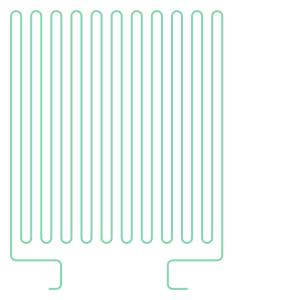

In [24]:
segments_line

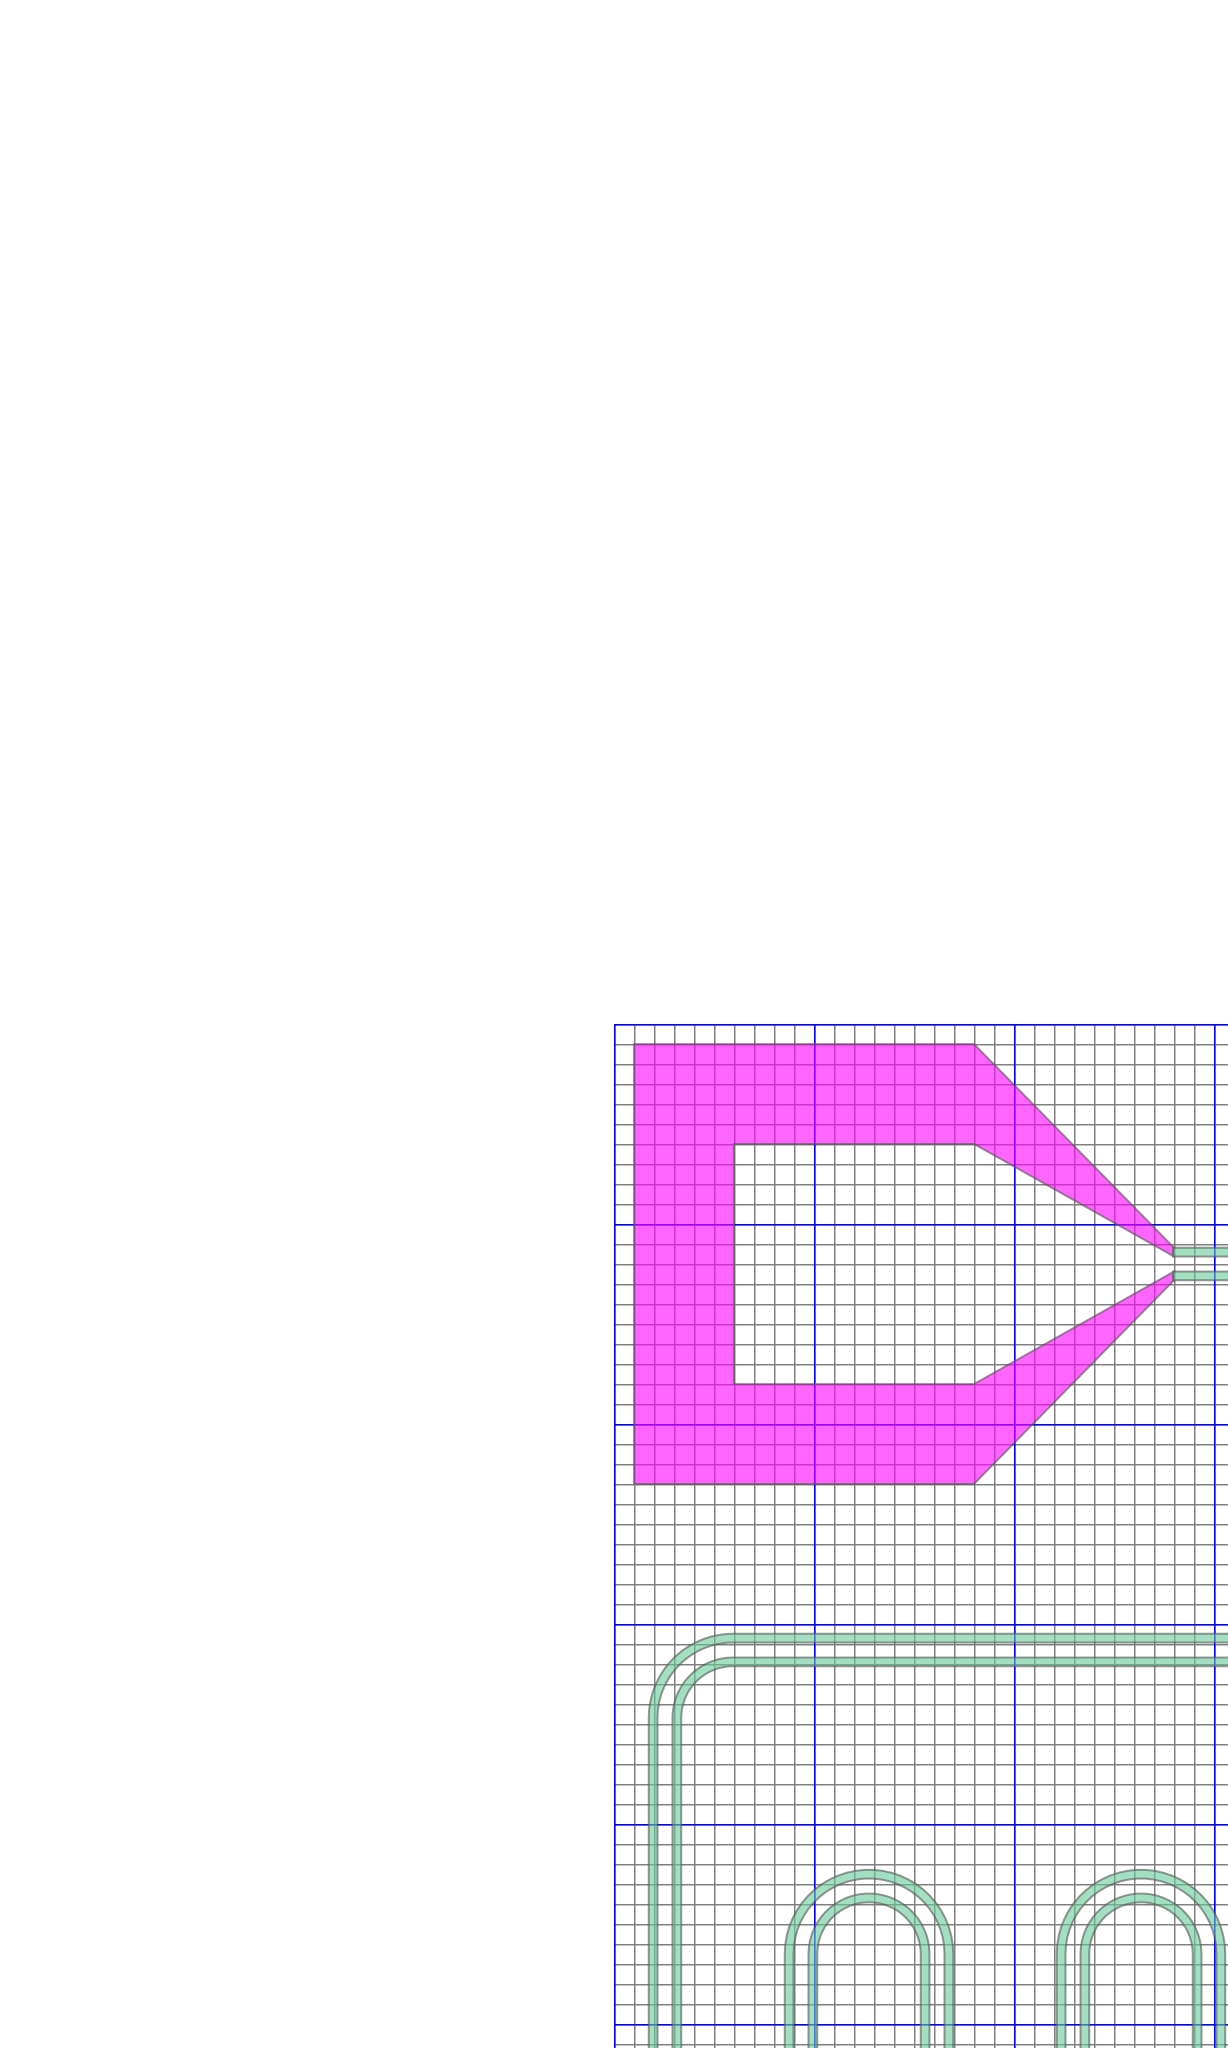

In [25]:
disp.display_svg([
    disp.generate_svg_grid(0,0,5000,5000,20,200,dattrib={"stroke-width":"3"},Dattrib={"stroke-width":"3"}),
    disp.nice_svg( launchL, attribs={'fill':'#ff0'} ),
    disp.nice_svg( launchR, attribs={'fill':'#f0f'} ),
    disp.nice_svg( my_line, attribs={'fill':'#000'} ),
    #disp.nice_svg( feed_lineR, attribs={'fill':'#0f0'} ),
], (0,0,WF,5000)
)

### Exporting
Save as, dxf as well as .gds file, also save a read only version of the notebook generating the .dxf and .gds files.

In [26]:
gdss = []
for p in my_line:
    gdss.append( gds.poly_to_gds(p, layer=1) )

for p in launchers:
    gdss.append( gds.poly_to_gds(p, layer=3) )
    
gds.save_gds_polys( gdss, "./FMR_CPW_1a_v2", save_notebook = False)